# Project 5: Classifying Point Clouds with PointNet

For this project, we are going to build deep learning architectures to classify point clouds that were extracted from self-driving car LiDAR scans.

Basic learning objectives of this project:
* Construct the basic pipeline used for point cloud classification
* Analyze the results from our model and look for potential points of improvement
* Understand the limitations of the model and improve it using positional encodings

## Setup

In [224]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import torch
from vision.utils import verify

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [225]:
device = torch.device('cpu')
# If you have an NVIDIA GPU with at least 2 GB of VRAM, set this to True
use_cuda = False
# If you have an Apple Silicon Mac, set this to True
use_apple_silicon = False
if torch.cuda.is_available():
    if use_cuda:
        device = torch.device('cuda')
        print("CUDA-compatible NVIDIA GPU enabled.")
    else:
        print("CUDA-compatible NVIDIA GPU detected. Consider setting use_cuda to True.")
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    if use_apple_silicon:
        device = torch.device('mps')
        print("Apple Silicon GPU enabled.")
    else:
        print("Apple Silicon GPU detected. Consider setting use_apple_silicon to True.")
        

print("Using device: %s" % str(device))

Apple Silicon GPU detected. Consider setting use_apple_silicon to True.
Using device: cpu


Lets take a second to visualize a few point clouds that we are going to train our model on. You might need to rotate the visualization before you can actually see the object being represented by the points. See if you can make out this pedestrian's arms, legs, and head.

In [226]:
from vision.utils import plot_cloud_from_file

plot_cloud_from_file('data/sweeps/PEDESTRIAN/11.txt')

## Part 1: Data Loading

The first order of business we're going to take care of is writing a PyTorch dataset that will load in the data we'll be using to train and test our model. We have a total of 20 different classes that all found under the `data/sweeps` folder and each class has been split into a training and testing set. We will write a class that will load the appropriate data given the split we pass in (i.e. train/test split).

**TODO 1:** complete `part1_dataloader.py`

In [227]:
from vision.part1_dataloader import Argoverse
from torch.utils.data import DataLoader
from tests.test_part1 import (
    test_dataset_length, 
    test_unique_values, 
    test_get_points_from_file, 
    test_pad_points, 
    test_class_values
)

In [228]:
print("test_dataset_length(): ", verify(test_dataset_length))
print("test_unique_values(): ", verify(test_unique_values))
print("test_get_points_from_file(): ", verify(test_get_points_from_file))
print("test_pad_points(): ", verify(test_pad_points))
print("test_class_values(): ", verify(test_class_values))

test_dataset_length():  "Correct"
test_unique_values():  "Correct"
test_get_points_from_file():  "Correct"
test_pad_points():  "Correct"
test_class_values():  "Correct"


Now we can load in our data. When extracting object point clouds from LiDAR scans, we pruned point clouds with large numbers of points to reduce the computational demand of training and testing our classifiers. We pruned all point clouds to have a maximum of 200 points so that is the size that we will be padding all of the other point clouds to. (Feel free to adjust the batch size if you find a value that works better with your implementation)

In [229]:
train_dataset = Argoverse('train', 'data/sweeps', 200)
test_dataset = Argoverse('test', 'data/sweeps', 200)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

## Part 2: Baseline

A very simple baseline to start with is a voxel-based approach. Our overall point cloud falls in a 4x4x4 meter volume in space. We can divide this up into 1x1x1 meter volumes which would give us a total of 64 $1m^3$ cells. We build a 64-dimensional feature for a point by simply counting how many points in the point cloud fall into each cell then normalizng the resulting feature vector.

For more details see the project pdf.

**TODO 2:** complete `part2_baseline.py`

In [230]:
from vision.part2_baseline import Baseline
from torch import optim
from vision.training import train, test
from tests.test_part2 import (
    test_count_points,
    test_baseline
)

In [231]:
print("test_count_points(): ", verify(test_count_points))
print("test_baseline(): ", verify(test_baseline))

test_count_points():  "Correct"
test_baseline():  "Correct"


Lets train our baseline implementation and see how it does! Fill in the hyperparameters and train your model. 

To get full credit for this section, you will need *$\geq$ 30%* accuracy on the test data set. The TAs were able to consistently achieve this accuracy with ~15 epochs.

*Hint: Play around with different voxel resolutions and the two different modes you implemented to see which configuration works the best.*

In [232]:
lr = 0.05
weight_decay = 1e-4
epochs = 10

model = Baseline(20, voxel_resolution=8, mode="occupancy")
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

In [233]:
train_acc, train_loss, test_acc, test_loss = train(model, optimizer, epochs, train_loader, test_loader)

Epoch 1

Training...


  0%|          | 0/213 [00:00<?, ?it/s]

100%|██████████| 213/213 [00:01<00:00, 174.31it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 234.51it/s]



Epoch 1 Stats:
	Training accuracy: 0.5918
	Training loss: 1.4263
	Validation accuracy: 0.4567
	Validation loss: 2.3072

Validation accuracy improved from 0 to 0.4566666781902313
Saving model to Baseline.pt


Epoch 2

Training...


100%|██████████| 213/213 [00:00<00:00, 302.83it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 339.88it/s]



Epoch 2 Stats:
	Training accuracy: 0.7179
	Training loss: 0.8682
	Validation accuracy: 0.4833
	Validation loss: 2.3599

Validation accuracy improved from 0.4566666781902313 to 0.4833333194255829
Saving model to Baseline.pt


Epoch 3

Training...


100%|██████████| 213/213 [00:00<00:00, 307.00it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 360.89it/s]



Epoch 3 Stats:
	Training accuracy: 0.7526
	Training loss: 0.7381
	Validation accuracy: 0.4600
	Validation loss: 2.7288


Epoch 4

Training...


100%|██████████| 213/213 [00:00<00:00, 304.02it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 339.10it/s]



Epoch 4 Stats:
	Training accuracy: 0.7606
	Training loss: 0.6988
	Validation accuracy: 0.4367
	Validation loss: 2.8589


Epoch 5

Training...


100%|██████████| 213/213 [00:00<00:00, 301.55it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 335.93it/s]



Epoch 5 Stats:
	Training accuracy: 0.7629
	Training loss: 0.6919
	Validation accuracy: 0.4583
	Validation loss: 2.6348


Epoch 6

Training...


100%|██████████| 213/213 [00:00<00:00, 295.77it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 336.03it/s]



Epoch 6 Stats:
	Training accuracy: 0.7788
	Training loss: 0.6505
	Validation accuracy: 0.4833
	Validation loss: 2.9046


Epoch 7

Training...


100%|██████████| 213/213 [00:00<00:00, 280.12it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 163.65it/s]



Epoch 7 Stats:
	Training accuracy: 0.7700
	Training loss: 0.6706
	Validation accuracy: 0.4550
	Validation loss: 3.0183


Epoch 8

Training...


100%|██████████| 213/213 [00:00<00:00, 269.73it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 324.77it/s]



Epoch 8 Stats:
	Training accuracy: 0.7674
	Training loss: 0.6885
	Validation accuracy: 0.4333
	Validation loss: 3.0855


Epoch 9

Training...


100%|██████████| 213/213 [00:00<00:00, 249.45it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 327.60it/s]



Epoch 9 Stats:
	Training accuracy: 0.7679
	Training loss: 0.6540
	Validation accuracy: 0.4450
	Validation loss: 2.9072


Epoch 10

Training...


100%|██████████| 213/213 [00:00<00:00, 284.22it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 328.98it/s]


Epoch 10 Stats:
	Training accuracy: 0.7735
	Training loss: 0.6576
	Validation accuracy: 0.4667
	Validation loss: 2.8307




In [234]:
model = torch.load('output/Baseline.pt')
test_acc, test_loss = test(model, test_loader)

/var/folders/zt/lq569kjj6f5f4wqklbbzk7r40000gn/T/ipykernel_28856/2856288945.py:1: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

100%|██████████| 38/38 [00:00<00:00, 307.43it

Test accuracy: 0.4833
Test loss: 2.3677


## Part 3: PointNet

Now that we have a baseline to compare to, we're going to build a simplified version of PointNet which was first published in 2017 by researchers at Stanford University. You can view the original website for this publication [here](https://stanford.edu/~rqi/pointnet/). 

We will be slightly modifying the original architecture. The architecture described in the PointNet publication includes two modules that we will not be implementing. Namely, they are the input transform and the feature transform. We will also not be using our PointNet implementation for semantic segmentation so you can ignore that part of the architecture as well. For an architecture diagram of what we will be implementing, check the project pdf.

**TODO 3**: complete `part3_pointnet.py`, use the architecture diagram in the project pdf for reference.

In [235]:
from tests.test_part3 import test_pointnet
from vision.part3_pointnet import PointNet

In [236]:
print("test_pointnet(): ", verify(test_pointnet))

test_pointnet():  "Correct"


Now that we have a PointNet implementation, lets train our model and see how it does. Fill in the hyper-parameters and give your new model a spin! 

To get full credit for this section, you will need *$\geq$ 60% accuracy* on the test dataset. The TAs were able to consistently achieve this accuracy with ~15 epochs of training.

In [237]:
lr = 0.001
weight_decay = 1e-4
epochs = 10

model = PointNet(classes=20)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

In [238]:
train_acc, train_loss, test_acc, test_loss = train(model, optimizer, epochs, train_loader, test_loader, device=device)

Epoch 1

Training...


100%|██████████| 213/213 [00:04<00:00, 49.44it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 114.44it/s]



Epoch 1 Stats:
	Training accuracy: 0.4706
	Training loss: 1.6656
	Validation accuracy: 0.4183
	Validation loss: 1.6865

Validation accuracy improved from 0 to 0.4183333218097687
Saving model to PointNet.pt


Epoch 2

Training...


100%|██████████| 213/213 [00:04<00:00, 46.13it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 157.04it/s]



Epoch 2 Stats:
	Training accuracy: 0.6312
	Training loss: 1.1498
	Validation accuracy: 0.5117
	Validation loss: 1.4143

Validation accuracy improved from 0.4183333218097687 to 0.5116666555404663
Saving model to PointNet.pt


Epoch 3

Training...


100%|██████████| 213/213 [00:03<00:00, 57.46it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 156.47it/s]



Epoch 3 Stats:
	Training accuracy: 0.6774
	Training loss: 0.9911
	Validation accuracy: 0.5583
	Validation loss: 1.3158

Validation accuracy improved from 0.5116666555404663 to 0.5583333373069763
Saving model to PointNet.pt


Epoch 4

Training...


100%|██████████| 213/213 [00:03<00:00, 54.50it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 149.84it/s]



Epoch 4 Stats:
	Training accuracy: 0.7047
	Training loss: 0.8954
	Validation accuracy: 0.5183
	Validation loss: 1.5802


Epoch 5

Training...


100%|██████████| 213/213 [00:03<00:00, 57.04it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 148.93it/s]



Epoch 5 Stats:
	Training accuracy: 0.7238
	Training loss: 0.8636
	Validation accuracy: 0.5383
	Validation loss: 1.4068


Epoch 6

Training...


100%|██████████| 213/213 [00:03<00:00, 57.33it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 152.24it/s]



Epoch 6 Stats:
	Training accuracy: 0.7471
	Training loss: 0.7750
	Validation accuracy: 0.5683
	Validation loss: 1.4294

Validation accuracy improved from 0.5583333373069763 to 0.5683333277702332
Saving model to PointNet.pt


Epoch 7

Training...


100%|██████████| 213/213 [00:03<00:00, 54.37it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 155.25it/s]



Epoch 7 Stats:
	Training accuracy: 0.7762
	Training loss: 0.7192
	Validation accuracy: 0.5567
	Validation loss: 1.2935


Epoch 8

Training...


100%|██████████| 213/213 [00:03<00:00, 57.41it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 151.58it/s]



Epoch 8 Stats:
	Training accuracy: 0.7706
	Training loss: 0.7112
	Validation accuracy: 0.6017
	Validation loss: 1.3505

Validation accuracy improved from 0.5683333277702332 to 0.6016666889190674
Saving model to PointNet.pt


Epoch 9

Training...


100%|██████████| 213/213 [00:03<00:00, 57.85it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 155.67it/s]



Epoch 9 Stats:
	Training accuracy: 0.7724
	Training loss: 0.6916
	Validation accuracy: 0.5567
	Validation loss: 1.2807


Epoch 10

Training...


100%|██████████| 213/213 [00:03<00:00, 57.24it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 154.00it/s]


Epoch 10 Stats:
	Training accuracy: 0.7888
	Training loss: 0.6224
	Validation accuracy: 0.5783
	Validation loss: 1.3615




In [239]:
model = torch.load('output/PointNet.pt', map_location='cpu')
test_acc, test_loss = test(model, test_loader)

/var/folders/zt/lq569kjj6f5f4wqklbbzk7r40000gn/T/ipykernel_28856/2270301145.py:1: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

100%|██████████| 38/38 [00:00<00:00, 150.30it

Test accuracy: 0.6017
Test loss: 1.3308


## Part 4: Performance Analysis

Now that we have a trained PointNet model, we can look at how it performs and what its shortcomings are. We are also going to analyze our point clouds to see which parts of them the model deemed to be most important in making its classification decision.

**TODO 4:** complete `part4_analysis.py`

In [240]:
from vision.utils import (
    generate_and_plot_confusion_matrix,
    plot_crit_points_from_file
)
from tests.test_part4 import (
    test_critical_indices,
    test_critical_indices_with_duplicates,
    test_confusion_matrix,
    test_confusion_matrix_normalized
)

In [241]:
print("test_critical_indices(): ", verify(test_critical_indices))
print("test_critical_indices_with_duplicates(): ", verify(test_critical_indices_with_duplicates))
print("test_confusion_matrix(): ", verify(test_confusion_matrix))
print("test_confusion_matrix_normalized(): ", verify(test_confusion_matrix_normalized))

test_critical_indices():  "Correct"
test_critical_indices_with_duplicates():  "Correct"
test_confusion_matrix():  "Correct"
test_confusion_matrix_normalized():  "Correct"


Lets use the confusion matrix to look at which mistakes our model is making most often.

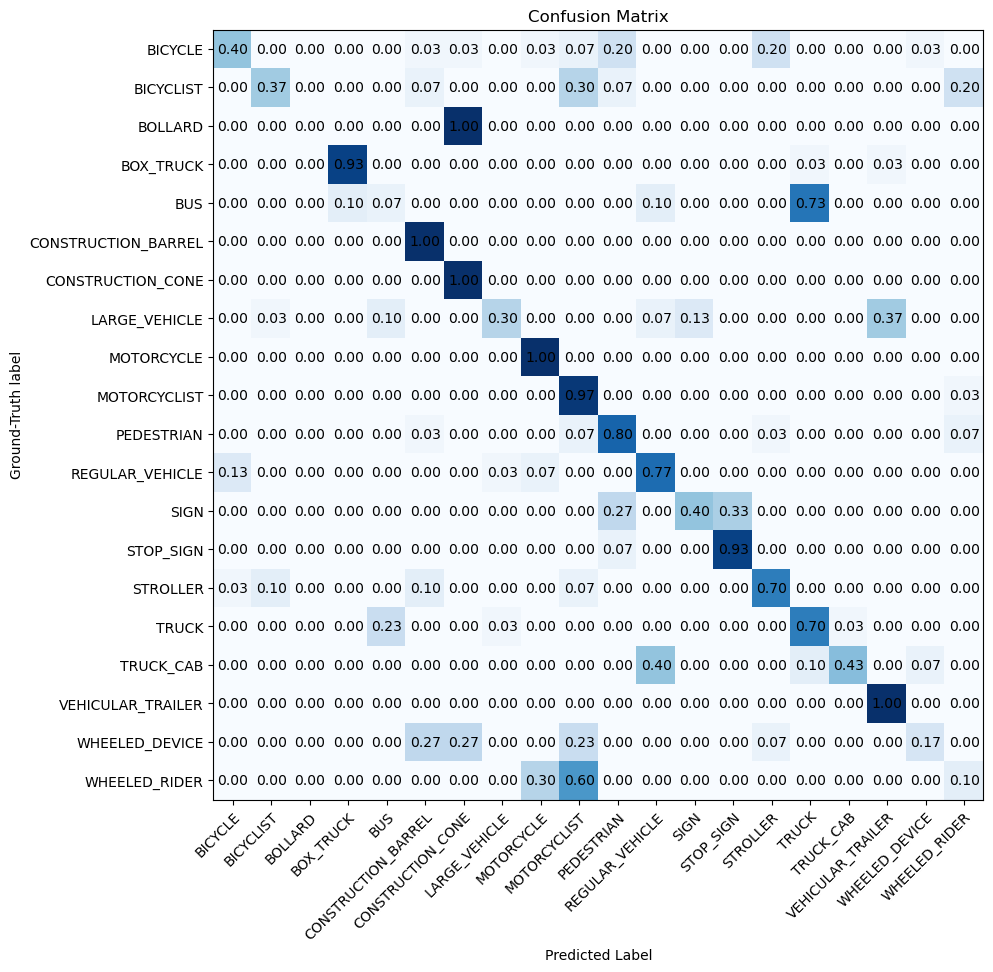

In [242]:
generate_and_plot_confusion_matrix(model, test_loader, 20)

Now lets visualize the critical points calculated by our model for the predestrian clouds from before. Recall that these are the points that contributed to the global feature. Why do you think these were the critical points the model ended up using? (Feel free to use different point clouds for your analysis)

In [243]:
plot_crit_points_from_file(model, 'data/sweeps/PEDESTRIAN/11.txt', 200)

## Part 5: T-Net

Our basic PointNet model does pretty well. But let's see if we can do any better. One proposed solution to improve on the shortcomings of the basic PointNet model is using a T-Net (see pdf for more details). 

**TODO 5:** complete `part5_tnet.py`

In [244]:
from vision.part5_tnet import PointNetTNet
from tests.test_part5 import (
    test_tnet_shapes,
    test_pointnet_tnet
)

In [245]:
print("test_tnet_shapes(): ", verify(test_tnet_shapes))
print("test_pointnet_tnet(): ", verify(test_pointnet_tnet))

test_tnet_shapes():  "Correct"
test_pointnet_tnet():  "Correct"


Let's check out how our model performs now that we added a T-Net.

To get full credit for this section, you will need *$\geq$ 65% accuracy* on the test dataset. The TAs were able to consistently achieve this accuracy with ~10 epochs of training.

*Hint: You may need to play around with the number of layers in the T-Net*

In [246]:
lr = 0.002
weight_decay = 1e-4
epochs = 10

model = PointNetTNet(classes=20)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

In [247]:
train_acc, train_loss, test_acc, test_loss = train(model, optimizer, epochs, train_loader, test_loader, device=device)

Epoch 1

Training...


100%|██████████| 213/213 [00:06<00:00, 30.62it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 90.23it/s]



Epoch 1 Stats:
	Training accuracy: 0.3306
	Training loss: 1.9451
	Validation accuracy: 0.2450
	Validation loss: 1.9826

Validation accuracy improved from 0 to 0.24500000476837158
Saving model to PointNetTNet.pt


Epoch 2

Training...


100%|██████████| 213/213 [00:07<00:00, 29.15it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 82.23it/s]



Epoch 2 Stats:
	Training accuracy: 0.5588
	Training loss: 1.3394
	Validation accuracy: 0.4100
	Validation loss: 1.5995

Validation accuracy improved from 0.24500000476837158 to 0.4099999964237213
Saving model to PointNetTNet.pt


Epoch 3

Training...


100%|██████████| 213/213 [00:06<00:00, 30.78it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 88.58it/s]



Epoch 3 Stats:
	Training accuracy: 0.6459
	Training loss: 1.0754
	Validation accuracy: 0.5000
	Validation loss: 1.6881

Validation accuracy improved from 0.4099999964237213 to 0.5
Saving model to PointNetTNet.pt


Epoch 4

Training...


100%|██████████| 213/213 [00:07<00:00, 27.13it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 77.14it/s]



Epoch 4 Stats:
	Training accuracy: 0.6847
	Training loss: 0.9699
	Validation accuracy: 0.5267
	Validation loss: 1.5643

Validation accuracy improved from 0.5 to 0.5266666412353516
Saving model to PointNetTNet.pt


Epoch 5

Training...


100%|██████████| 213/213 [00:07<00:00, 29.38it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 89.41it/s]



Epoch 5 Stats:
	Training accuracy: 0.7115
	Training loss: 0.8802
	Validation accuracy: 0.5200
	Validation loss: 1.4543


Epoch 6

Training...


100%|██████████| 213/213 [00:06<00:00, 30.85it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 89.20it/s]



Epoch 6 Stats:
	Training accuracy: 0.7371
	Training loss: 0.8406
	Validation accuracy: 0.4733
	Validation loss: 1.6002


Epoch 7

Training...


100%|██████████| 213/213 [00:06<00:00, 30.52it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 84.83it/s]



Epoch 7 Stats:
	Training accuracy: 0.7526
	Training loss: 0.7744
	Validation accuracy: 0.5783
	Validation loss: 1.2039

Validation accuracy improved from 0.5266666412353516 to 0.57833331823349
Saving model to PointNetTNet.pt


Epoch 8

Training...


100%|██████████| 213/213 [00:07<00:00, 28.52it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 76.61it/s]



Epoch 8 Stats:
	Training accuracy: 0.7718
	Training loss: 0.6972
	Validation accuracy: 0.5733
	Validation loss: 1.4199


Epoch 9

Training...


100%|██████████| 213/213 [00:08<00:00, 25.20it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 68.92it/s]



Epoch 9 Stats:
	Training accuracy: 0.7838
	Training loss: 0.6822
	Validation accuracy: 0.6483
	Validation loss: 1.1179

Validation accuracy improved from 0.57833331823349 to 0.6483333110809326
Saving model to PointNetTNet.pt


Epoch 10

Training...


100%|██████████| 213/213 [00:08<00:00, 25.77it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 75.82it/s]



Epoch 10 Stats:
	Training accuracy: 0.7862
	Training loss: 0.6499
	Validation accuracy: 0.5117
	Validation loss: 1.5599




In [248]:
model = torch.load('output/PointNetTNet.pt', map_location='cpu')
test_acc, test_loss = test(model, test_loader)

/var/folders/zt/lq569kjj6f5f4wqklbbzk7r40000gn/T/ipykernel_28856/4218532974.py:1: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

100%|██████████| 38/38 [00:00<00:00, 72.38it/

Test accuracy: 0.6483
Test loss: 1.1198


Lets take a look at how the addition of positional encoding improved on the performance of our original PointNet model. Which classes does the positional encoding help the most with? Which ones does it not really seem to make much of a difference for? Why?

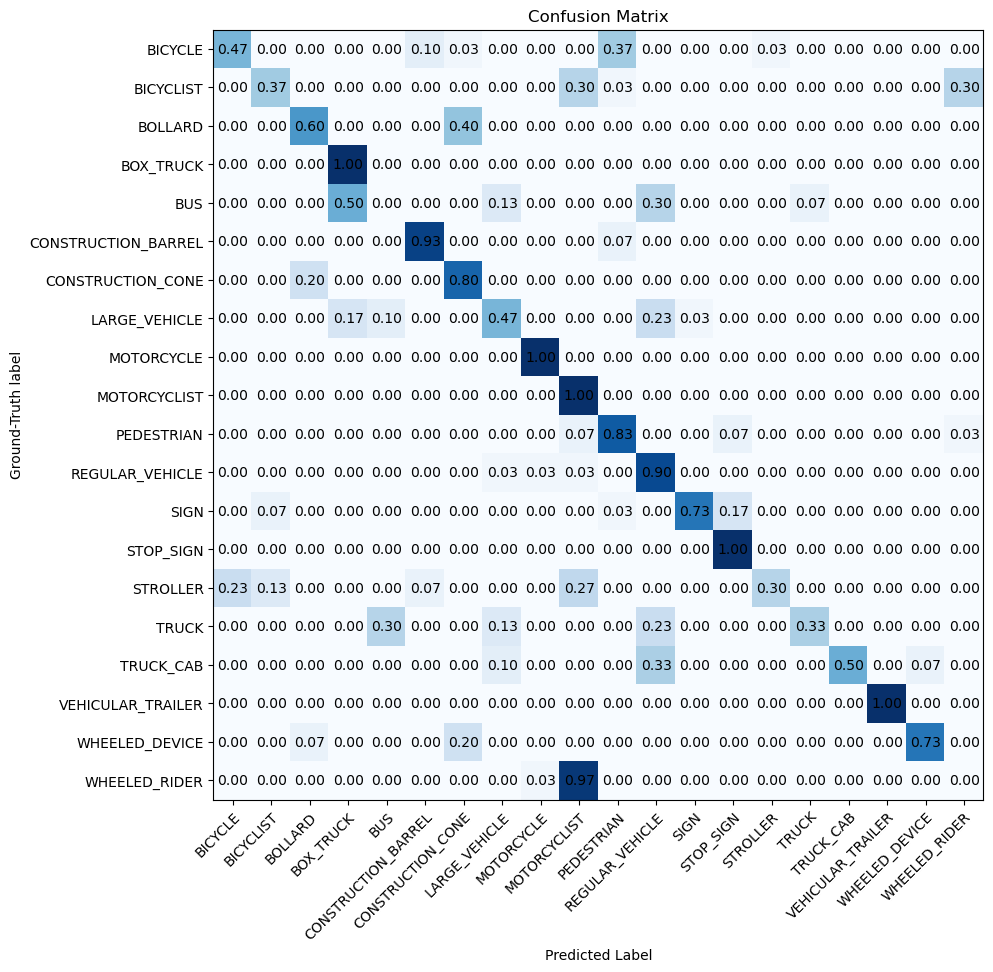

In [249]:
generate_and_plot_confusion_matrix(model, test_loader, 20)

In [250]:
plot_crit_points_from_file(model, 'data/sweeps/PEDESTRIAN/11.txt', 200)